- knn con vecinos cercanos considerando pickup and dropoff data
- knn con el respecto al día de la semana (finde o no)
    -- hacer esto con todos los datos temporales (lunes a viernes y sábado y domingo) 
- distancia ==> sklearn.metrics.pairwise
    -- manhattan, euclidean, canberra, minkowski, cosine (Jere va a leer porque sí)

# Contexto

#### Contexto  
El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

# Librerías

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

import holidays

from sklearn.impute import KNNImputer
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler   # u otros scalers
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Carga de datos




In [88]:
### carga datos de dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)


In [22]:
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [18]:
df.isna().sum()

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

# Análisis descriptivo

## Análisis exploratorio

In [68]:
# Dropeo filas donde el valor del viaje es nulo o negativo

df = df[df["fare_amount"].notna()]               # remove NaN / None
df = df[df["fare_amount"].astype(float) > 0]

df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [69]:
# separo timestamp en date y time
df["dateTime"] = pd.to_datetime(df["pickup_datetime"]) # sin errors, ya que checkeamos que no hay valores nulos
df["dateTime"] = df["dateTime"].dt.tz_convert("America/New_York") # Esto cubre el horario de verano

df["time"] = df["dateTime"].dt.time
df["date"] = df["dateTime"].dt.date

print(df)


             key        date  fare_amount          pickup_datetime  \
0       24238194  2015-05-07          7.5  2015-05-07 19:52:06 UTC   
1       27835199  2009-07-17          7.7  2009-07-17 20:04:56 UTC   
2       44984355  2009-08-24         12.9  2009-08-24 21:45:00 UTC   
3       25894730  2009-06-26          5.3  2009-06-26 08:22:21 UTC   
4       17610152  2014-08-28         16.0  2014-08-28 17:47:00 UTC   
...          ...         ...          ...                      ...   
199995  42598914  2012-10-28          3.0  2012-10-28 10:49:00 UTC   
199996  16382965  2014-03-13          7.5  2014-03-14 01:09:00 UTC   
199997  27804658  2009-06-28         30.9  2009-06-29 00:42:00 UTC   
199998  20259894  2015-05-20         14.5  2015-05-20 14:56:25 UTC   
199999  11951496  2010-05-15         14.1  2010-05-15 04:08:00 UTC   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.999817        40.738354         -73.999512   
1             -73.994355       

In [25]:
print(df["dateTime"].dt.hour)

0         15
1         16
2         17
3          4
4         13
          ..
199995     6
199996    21
199997    20
199998    10
199999     0
Name: dateTime, Length: 199978, dtype: int32


In [70]:
df["date"] = pd.to_datetime(df["date"])
df["weekday_num"] = df["date"].dt.dayofweek + 1



In [71]:
print(df["weekday_num"])

k = (2*math.pi)/7 # 7 por los días de la semana

df["sen_weekday_num"] = np.sin(k*df["weekday_num"])
df["cos_weekday_num"] = np.cos(k*df["weekday_num"])

print(df)

0         4
1         5
2         1
3         5
4         4
         ..
199995    7
199996    4
199997    7
199998    3
199999    6
Name: weekday_num, Length: 199978, dtype: int32
             key       date  fare_amount          pickup_datetime  \
0       24238194 2015-05-07          7.5  2015-05-07 19:52:06 UTC   
1       27835199 2009-07-17          7.7  2009-07-17 20:04:56 UTC   
2       44984355 2009-08-24         12.9  2009-08-24 21:45:00 UTC   
3       25894730 2009-06-26          5.3  2009-06-26 08:22:21 UTC   
4       17610152 2014-08-28         16.0  2014-08-28 17:47:00 UTC   
...          ...        ...          ...                      ...   
199995  42598914 2012-10-28          3.0  2012-10-28 10:49:00 UTC   
199996  16382965 2014-03-13          7.5  2014-03-14 01:09:00 UTC   
199997  27804658 2009-06-28         30.9  2009-06-29 00:42:00 UTC   
199998  20259894 2015-05-20         14.5  2015-05-20 14:56:25 UTC   
199999  11951496 2010-05-15         14.1  2010-05-15 04:08:00

In [72]:

us_holidays = holidays.US(state="NY")

df["weekend_or_holiday"] = ((df["weekday_num"] >= 6) | (df["date"].dt.date.isin(us_holidays))).astype(int)


In [73]:
# 1 a 7 ==> madrugada ==> V = 1  ==> CODIFICACIÓN BINARIA ==> 0 | 0
# 7 a 11 ==> mañana ==> V = 2 ==> CODIFICACIÓN BINARIA ==> 0 | 1
# 11 a 19 ==> tarde ==> V = 3 ==> CODIFICACIÓN BINARIA ==> 1 | 1
# 19 a 1 ==> noche ==> V = 4 ==> CODIFICACIÓN BINARIA ==> 1 | 0

df["time"] = df["dateTime"].dt.hour

df["bin_time_1"] = 0
df["bin_time_2"] = 0

df.loc[(df["time"] >= 7) & (df["time"] < 11), ["bin_time_1", "bin_time_2"]] = [0, 1]
df.loc[(df["time"] >= 11) & (df["time"] < 19), ["bin_time_1", "bin_time_2"]] = [1, 1]
df.loc[(df["time"] >= 19) | (df["time"] < 1), ["bin_time_1", "bin_time_2"]] = [1, 0]

In [74]:
k_week= 2*np.pi/52

df["week"] = df["date"].dt.isocalendar().week

df["sen_week_num"] = np.sin(k_week*df["week"])
df["cos_week_num"] = np.cos(k_week*df["week"])

In [75]:
df.loc[(df['passenger_count'] < 0), 'passenger_count'] = 1
df.loc[(df['passenger_count'] > 6), 'passenger_count'] = 6

In [76]:
# INVIERNO: de diciembre a febrero ==> CODIFICACIÓN BINARIA ==> 0 | 0
# PRIMAVERA: de marzo a mayo ==> CODIFICACIÓN BINARIA ==> 0 | 1
# VERANO: de junio a agosto ==> CODIFICACIÓN BINARIA ==> 1 | 1
# OTOÑO: de septiembre a noviembre ==> CODIFICACIÓN BINARIA ==> 1 | 0

df['month'] = df['date'].dt.month

df.loc[(df['month'] >= 3) & (df['month'] < 6), ["bin_month_1", "bin_month_2"]] = [0, 1]
df.loc[(df['month'] >= 6) & (df['month'] < 9), ["bin_month_1", "bin_month_2"]] = [1, 1]
df.loc[(df['month'] >= 9) & (df['month'] < 12), ["bin_month_1", "bin_month_2"]] = [1, 0]
df.loc[(df['month'] == 12) | (df['month'] < 3), ["bin_month_1", "bin_month_2"]] = [0, 0]

In [15]:
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dateTime', 'time', 'weekday_num', 'sen_weekday_num',
       'cos_weekday_num', 'weekend_or_holiday', 'bin_time_1', 'bin_time_2',
       'week', 'sen_week_num', 'cos_week_num', 'month', 'bin_month_1',
       'bin_month_2'],
      dtype='object')

Official source

The NYC Department of City Planning (DCP) provides the NYC Borough Boundary shapefile (“nybb”) that defines the boundary clipped to the shoreline. 
s-media.nyc.gov

The metadata for that dataset gives the bounding box of that official polygon: West −74.257159°, East −73.699215°, North 40.915568°, South 40.496010°

longitud ==> este oeste

latitud ==> norte sur

In [92]:
# Set invalid coordinates to 0 (or None / NaN if you prefer)
df.loc[df["pickup_latitude"] > 41, ["pickup_latitude"]] = np.nan
df.loc[df["pickup_latitude"] < 40, ["pickup_latitude"]] = np.nan
df.loc[df["dropoff_latitude"] > 41, ["dropoff_latitude"]] = np.nan
df.loc[df["dropoff_latitude"] < 40, ["dropoff_latitude"]] = np.nan

df.loc[df["pickup_longitude"] > -73.50, ["pickup_longitude"]] = np.nan
df.loc[df["pickup_longitude"] < -74, ["pickup_longitude"]] = np.nan
df.loc[df["dropoff_longitude"] > -73.50, ["dropoff_longitude"]] = np.nan
df.loc[df["dropoff_longitude"] < -74, ["dropoff_longitude"]] = np.nan



    # "pickup_latitude":  (df["pickup_latitude"] > 40.91) | (df["pickup_latitude"] < 40.49),
    # "dropoff_latitude": (df["dropoff_latitude"] > 40.91) | (df["dropoff_latitude"] < 40.49),
    # "pickup_longitude": (df["pickup_longitude"] > -73.70) | (df["pickup_longitude"] < -74.25),
    # "dropoff_longitude": (df["dropoff_longitude"] > -73.70) | (df["dropoff_longitude"] < -74.25),

Con estos valores hacemos KNN para setearlos

In [93]:
cols = ["pickup_latitude", "dropoff_latitude", "pickup_longitude", "dropoff_longitude"]

df[cols] = df[cols].replace(0.0, np.nan)

conditions = {
    "pickup_latitude":  (df["pickup_latitude"] > 40.91) | (df["pickup_latitude"] < 40.49),
    "dropoff_latitude": (df["dropoff_latitude"] > 40.91) | (df["dropoff_latitude"] < 40.49),
    "pickup_longitude": (df["pickup_longitude"] > -73.70) | (df["pickup_longitude"] < -74.25),
    "dropoff_longitude": (df["dropoff_longitude"] > -73.70) | (df["dropoff_longitude"] < -74.25),
} #dentro de Nueva York

invalid_mask = (
    conditions["pickup_latitude"] |
    conditions["dropoff_latitude"] |
    conditions["pickup_longitude"] |
    conditions["dropoff_longitude"]
)

print(df.loc[invalid_mask, ["pickup_latitude", "dropoff_latitude", "pickup_longitude", "dropoff_longitude"]])

df[df["pickup_latitude"] ==  0.007380]



        pickup_latitude  dropoff_latitude  pickup_longitude  dropoff_longitude
696           40.190564         40.190564               NaN                NaN
917           40.750307         40.911958               NaN         -73.910177
1738          40.966745         40.960380        -73.867800         -73.855478
1905          40.221474         40.223950        -73.733760         -73.737622
2671          40.428030         40.422658        -73.902908         -73.931997
...                 ...               ...               ...                ...
196122        40.769707         40.975602        -73.866782         -73.886882
196616        40.749896         40.973143        -73.984697                NaN
197034        40.646700         40.653412        -73.781310         -73.691822
197604        40.724057         40.723995        -73.587592         -73.591222
197695        40.350780         40.358117        -73.573012         -73.548835

[164 rows x 4 columns]


,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count


In [96]:
from sklearn.impute import KNNImputer
import pandas as pd

# Select columns for imputation and features
cols_to_use = ['col1', 'col2', 'col3']  # Columns to impute and use as features
df_subset = df[cols_to_use]

# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=10)

# Perform imputation
df_imputed_subset = pd.DataFrame(knn_imputer.fit_transform(df_subset), 
                                columns=cols_to_use, 
                                index=df.index)

# Merge imputed columns back into the original DataFrame
df[cols_to_use] = df_imputed_subset

KeyError: "None of [Index(['col1', 'col2', 'col3'], dtype='object')] are in the [columns]"

In [97]:
conditions = {
    "pickup_latitude":  (df["pickup_latitude"] > 40.91) | (df["pickup_latitude"] < 40.49),
    "dropoff_latitude": (df["dropoff_latitude"] > 40.91) | (df["dropoff_latitude"] < 40.49),
    "pickup_longitude": (df["pickup_longitude"] > -73.70) | (df["pickup_longitude"] < -74.25),
    "dropoff_longitude": (df["dropoff_longitude"] > -73.70) | (df["dropoff_longitude"] < -74.25),
} #dentro de Nueva York

invalid_mask = (
    conditions["pickup_latitude"] |
    conditions["dropoff_latitude"] |
    conditions["pickup_longitude"] |
    conditions["dropoff_longitude"]
)

# Count how many rows are invalid
invalid_count = invalid_mask.sum()
print("Rows outside limits:", invalid_count)

# If you want to see the rows themselves
invalid_rows = df[invalid_mask]

print(df.loc[invalid_mask, ["pickup_latitude", "dropoff_latitude", "pickup_longitude", "dropoff_longitude"]])

Rows outside limits: 164
        pickup_latitude  dropoff_latitude  pickup_longitude  dropoff_longitude
696           40.190564         40.190564               NaN                NaN
917           40.750307         40.911958               NaN         -73.910177
1738          40.966745         40.960380        -73.867800         -73.855478
1905          40.221474         40.223950        -73.733760         -73.737622
2671          40.428030         40.422658        -73.902908         -73.931997
...                 ...               ...               ...                ...
196122        40.769707         40.975602        -73.866782         -73.886882
196616        40.749896         40.973143        -73.984697                NaN
197034        40.646700         40.653412        -73.781310         -73.691822
197604        40.724057         40.723995        -73.587592         -73.591222
197695        40.350780         40.358117        -73.573012         -73.548835

[164 rows x 4 columns]


In [51]:
(df[df["pickup_latitude"] > 40.91]).count()


key                  116
date                 116
fare_amount          116
pickup_datetime      116
pickup_longitude     116
pickup_latitude      116
dropoff_longitude    116
dropoff_latitude     116
passenger_count      116
dtype: int64

key                   1
date                  1
fare_amount           1
pickup_datetime       1
pickup_longitude      1
pickup_latitude       1
dropoff_longitude     1
dropoff_latitude      1
passenger_count       1
dateTime              1
time                  1
weekday_num           1
sen_weekday_num       1
cos_weekday_num       1
weekend_or_holiday    1
bin_time_1            1
bin_time_2            1
week                  1
sen_week_num          1
cos_week_num          1
dtype: int64


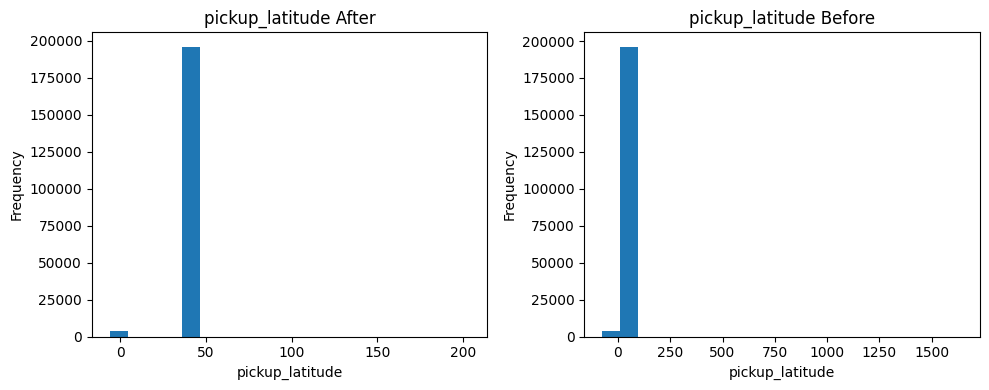

In [35]:
from sklearn.preprocessing import PowerTransformer

conditions = {
    "pickup_latitude":  (df["pickup_latitude"] > 40.91) | (df["pickup_latitude"] < 40.49),
    "dropoff_latitude": (df["dropoff_latitude"] > 40.91) | (df["dropoff_latitude"] < 40.49),
    "pickup_longitude": (df["pickup_longitude"] > -73.70) | (df["pickup_longitude"] < -74.25),
    "dropoff_longitude": (df["dropoff_longitude"] > -73.70) | (df["dropoff_longitude"] < -74.25),
}

# Transformer
pt = PowerTransformer(method="yeo-johnson", standardize=True)

# Apply transformation only to values matching each condition
for col, mask in conditions.items():
    if mask.any():  # only if outliers exist
        pt.fit(df[[col]])  # fit on the whole column for consistency
        df.loc[mask, col] = pt.transform(df.loc[mask, [col]])

# Show transformed DataFrame
print(df)

# --- Visualization example: before vs after pickup_latitude ---
fig, axes = plt.subplots(1, 2, figsize=(10,4))
df["pickup_latitude"].plot(kind="hist", bins=20, ax=axes[0], title="pickup_latitude After")
axes[0].set_xlabel("pickup_latitude")

# Just for comparison, original distribution (replace with a saved copy of df before transform)
df_orig =pd.read_csv(file_path)

df_orig["pickup_latitude"].plot(kind="hist", bins=20, ax=axes[1], title="pickup_latitude Before")
axes[1].set_xlabel("pickup_latitude")

plt.tight_layout()
plt.show()

In [17]:
### Busco duplicados
if not df.duplicated().any():
  print('No hay registros duplicados')

No hay registros duplicados


In [24]:
### Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dateTime', 'time', 'weekday_num', 'sen_weekday_num',
       'cos_weekday_num', 'weekend_or_holiday', 'bin_time_1', 'bin_time_2'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [8]:
# Valores nulos

df.isna().sum()

,0
key,0
date,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,1
dropoff_latitude,1
passenger_count,0


## Datos atípicos y faltantes

Valores atipicos o mal inputados
*   Para limitar las longitudes y latitudes dentro de los Estados Unidos, se pueden usar los rangos geográficos aproximados que corresponden a las fronteras del país. Los valores aproximados son: Latitudes: Desde 24.396308° N (en la frontera sur, en la Florida) hasta 49.384358° N (en la frontera norte, cerca de la línea entre EE. UU. y Canadá). Longitudes: Desde -125.0° W (en la costa oeste, en California) hasta -66.93457° W (en la costa este, en Maine).
*   un auto no puede llevar 208 pasajeros (el maximo es 6, en los uber XL)









In [15]:
# Imputamos por la moda de la columna 'passenger_count' las celdas que continen valores negativos o mayores que 6

def impute_passengers (df):
  '''
  Imputa las celdas que continen valores negativos o mayores que 6 en la columna
  'passenger_count' con la moda de la columna y devuelve el dataframe modificado
  '''
  passenger_mode = df['passenger_count'].mode()[0]
  df.loc[(df['passenger_count'] < 0) | (df['passenger_count'] > 6), 'passenger_count'] = passenger_mode
  return df

In [16]:
#  Imputamos por KNN las coordenadas inválidas

def impute_coordinates_train_test(X_train, X_test):
    """
    Imputa las coordenadas faltantes o inválidas por separado para train y test usando KNN.
    """
    # Columnas a imputar
    cols_to_impute = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

    # Crear copias para evitar modificar los originales
    X_train_imputed = X_train.copy()
    X_test_imputed = X_test.copy()

    # Marcar coordenadas inválidas como NaN
    for col in cols_to_impute:
        if 'longitude' in col:
            X_train_imputed.loc[(X_train_imputed[col] < -125.0) | (X_train_imputed[col] > -66.93457) | (X_train_imputed[col] == 0) | (X_train_imputed[col].isna()), col] = np.nan
            X_test_imputed.loc[(X_test_imputed[col] <  -125.0) | (X_test_imputed[col] > -66.93457) | (X_test_imputed[col] == 0) | (X_test_imputed[col].isna()), col] = np.nan
        elif 'latitude' in col:
            X_train_imputed.loc[(X_train_imputed[col] < 24.396308) | (X_train_imputed[col] >  49.384358) | (X_train_imputed[col] == 0) | (X_train_imputed[col].isna()), col] = np.nan
            X_test_imputed.loc[(X_test_imputed[col] < 24.396308) | (X_test_imputed[col] >  49.384358) | (X_test_imputed[col] == 0) | (X_test_imputed[col].isna()), col] = np.nan

    # Entrenar el imputador en el conjunto de entrenamiento
    imputer = KNNImputer(n_neighbors=10)
    imputer.fit(X_train_imputed[cols_to_impute])

    # Aplicar el imputador en ambos conjuntos (entrenamiento y prueba)
    X_train_imputed[cols_to_impute] = imputer.transform(X_train_imputed[cols_to_impute])
    X_test_imputed[cols_to_impute] = imputer.transform(X_test_imputed[cols_to_impute])

    return X_train_imputed, X_test_imputed

'''# Llamar a la función para imputar los conjuntos ESTO LO SACAMOS?
X_train_imputed, X_test_imputed = impute_coordinates_train_test(X_train, X_test)'''


'# Llamar a la función para imputar los conjuntos ESTO LO SACAMOS?\nX_train_imputed, X_test_imputed = impute_coordinates_train_test(X_train, X_test)'